**Meaning Classification with lambeq QNLP Toolkit**

Classical Pipeline Simulation

This tutorial is based on - https://cqcl.github.io/lambeq/tutorials/training-usecase.html

There are total 130 sentences in the data set where the training set has 70, development set has 30 and test set has 30. There are two kinds of sentences available which are related to either Maths or Music. This is a binary senence classification problem.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing necessary libraries**

In [ ]:
! pip install lambeq

     |████████████████████████████████| 364 kB 10.0 MB/s 
     |████████████████████████████████| 100 kB 9.2 MB/s 
  Created wheel for discopy: filename=discopy-0.3.7.1-py3-none-any.whl size=91600 sha256=9463492c28cc50b6bc8e30b19d91f86345142731b59d3a8d3618dd9e2fe45a38
  Stored in directory: /root/.cache/pip/wheels/dc/59/a1/9e765d9e150bad283ca03bf98c2c0ddd001f80078c3163e497
Successfully built discopy


In [ ]:
! pip install lambeq[depccg]

     |████████████████████████████████| 3.5 MB 7.1 MB/s 
     |████████████████████████████████| 880 kB 52.7 MB/s 
     |████████████████████████████████| 129 kB 46.1 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
     |████████████████████████████████| 1.2 MB 52.1 MB/s 
  Created wheel for depccg: filename=depccg-1.1.0-cp37-cp37m-linux_x86_64.whl size=13856206 sha256=0c855301520fb555431027b836bfa41fee22580db5201cc39e227c92f06f589a
  Stored in directory: /root/.cache/pip/wheels/85/94/1c/1ae7b6d4d94fa629ebf0a55c3558486494a207740f50e64a51
  Created wheel for chainer: filename=chainer-6.0.0-py3-none-any.whl size=876785 sha256=c78e5c107d94685a1adec429ed475ea8fb9486a45ca0c197ae7171b199f50177
  Stored in directory: /root/.cache/pip/wheels/cd/38/53/18c6578a40a10ff120db266e58c5e383c1cb7bdea79b6c418a
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=972934771a2861875ff58f80c37b9cdab808c235d284ad4ae9fc82ee410df014
  Stored in directory: /root/.

In [ ]:
! depccg_en download

**Importing libraries**

In [ ]:
from discopy.tensor import Tensor
from jax import numpy as np
import numpy

np.random = numpy.random
Tensor.np = np

**Reading and storing data in separate variables**

In [ ]:
# Read data
def read_data(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    data, targets = [], []
    for ln in lines:
        t = int(ln[0])
        data.append(ln[1:].strip())
        targets.append(np.array([t, not(t)], dtype=np.float32))
    return data, np.array(targets)

train_data, train_targets = read_data('/content/drive/MyDrive/mm_mc_train_data.txt')
test_data, test_targets = read_data('/content/drive/MyDrive/mm_mc_test_data.txt')
dev_data, dev_targets = read_data('/content/drive/MyDrive/mm_mc_dev_data.txt')

**Printing the training data**

In [ ]:
train_data[:10]

['skillful man teaches maths',
 'skillful man explains categories',
 'woman describes simple monoids',
 'man teaches monoids',
 'skillful woman plays music',
 'woman teaches simple monoids',
 'person listens music',
 'person listens intresting tunes',
 'woman teaches maths',
 'woman teaches categories']

**Printing the training labels**

In [ ]:
train_targets

DeviceArray([[1., 0.],
             [1., 0.],
             [1., 0.],
             ...,
             [0., 1.],
             [1., 0.],
             [0., 1.]], dtype=float32)

**Parsing sentences and converting them into string diagrams**

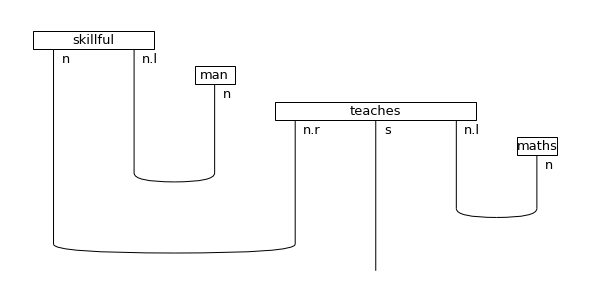

In [ ]:
# Parse sentences to diagrams

from lambeq.ccg2discocat import DepCCGParser

parser = DepCCGParser()
train_diagrams = parser.sentences2diagrams(train_data)
test_diagrams = parser.sentences2diagrams(test_data)

train_diagrams[0].draw(figsize=(8,4), fontsize=13)

**Converting the diagrams into circuit**

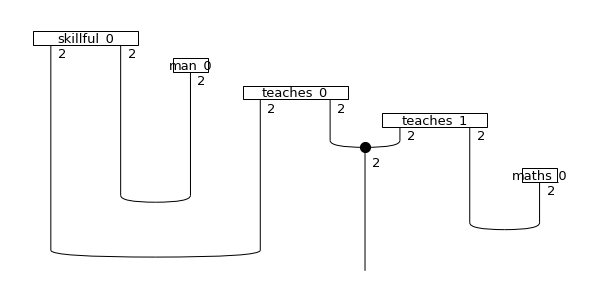

In [ ]:
# Create ansatz and convert to tensor diagrams

from lambeq.tensor import SpiderAnsatz
from lambeq.core.types import AtomicType
from discopy import Dim

N = AtomicType.NOUN
S = AtomicType.SENTENCE

# Create an ansatz by assigning 2 dimensions to both
# noun and sentence spaces
ansatz = SpiderAnsatz({N: Dim(2), S: Dim(2)})

train_circuits = [ansatz(d) for d in train_diagrams]
test_circuits = [ansatz(d) for d in test_diagrams]

all_circuits = train_circuits + test_circuits

all_circuits[0].draw(figsize=(8,4), fontsize=13)

**Sorting the symbols in circuits to collect the vocabulary and forming a list of tensors**

In [ ]:
# Create vocabulary

from sympy import default_sort_key

vocab = sorted(
   {sym for circ in all_circuits for sym in circ.free_symbols},
    key=default_sort_key
)
tensors = [np.random.rand(w.size) for w in vocab]

tensors[0]

array([0.99348281, 0.49709925])

**Defining functions for loss calculation which includes predictions**

The model is a simple binary classifier which is the Sigmoid or Logistic function

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def loss(tensors):
    # Lambdify
    np_circuits = [c.lambdify(*vocab)(*tensors) for c in train_circuits]
    # Compute predictions
    predictions =  sigmoid(np.array([c.eval().array for c in np_circuits]))

    # binary cross-entropy loss
    cost = -np.sum(train_targets * np.log2(predictions)) / len(train_targets)
    return cost

**Executing the training process and calculates gradient**

In [ ]:

from jax import jit, grad

training_loss = jit(loss)
gradient = jit(grad(loss))

In [ ]:
training_losses = []

epochs = 90

for i in range(epochs):

    gr = gradient(tensors)
    for k in range(len(tensors)):
        tensors[k] = tensors[k] - gr[k] * 1.0

    training_losses.append(float(training_loss(tensors)))

    if (i + 1) % 10 == 0:
        print(f"Epoch {i + 1} - loss {training_losses[-1]}")

Epoch 10 - loss 0.06509824097156525
Epoch 20 - loss 0.01211518608033657
Epoch 30 - loss 0.00577482720836997
Epoch 40 - loss 0.003607523860409856
Epoch 50 - loss 0.0025582807138562202
Epoch 60 - loss 0.001952469814568758
Epoch 70 - loss 0.001563129830174148
Epoch 80 - loss 0.0012942035682499409
Epoch 90 - loss 0.001098540029488504


**Testing of Sigmoid classifier**

In [ ]:
# Testing

np_test_circuits = [c.lambdify(*vocab)(*tensors) for c in test_circuits]
test_predictions =  sigmoid(np.array([c.eval().array for c in np_test_circuits]))

hits = 0
for i in range(len(np_test_circuits)):
    target = test_targets[i]
    pred = test_predictions[i]
    if np.argmax(target) == np.argmax(pred):
        hits += 1

print("Accuracy on test set:", hits / len(np_test_circuits))

Accuracy on test set: 0.8333333333333334
